In [1]:
import numpy as np
import cv2
import scipy.stats as stats
import mpmath as mp
import matplotlib.pyplot as plt
import seaborn as sns
import skimage


In [2]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
def see(img):
    plt.imshow(img)
    plt.show()

In [4]:
def getHSV_Image_and_Mask(img,mask):
    # import images (will be in bgr because of cv2)
    img_bgr = cv2.imread(img)
    mask_bgr = cv2.imread(mask)
    
    # binarise the mask because it contains grey pixels due to interpolation from jpeg compression:
    binary = skimage.filters.threshold_otsu(mask_bgr[:,:,0])
    m = mask_bgr[:,:,0]>binary
    
    # get r,g, and b of img_bgr:
    img_r = img_bgr[:,:,2]
    img_g = img_bgr[:,:,1]
    img_b = img_bgr[:,:,0]
    
    # convert img_bgr to HSV:
    img_hsv = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2HSV)
    
    # get H, S and V of img_hsv
    img_H = img_hsv[:,:,0]
    img_S = img_hsv[:,:,1]
    img_V = img_hsv[:,:,2]
    
    print('r,g,b,h,s,v, mask')
    see(img_r)
    see(img_g)
    see(img_b)
    see(img_H)
    see(img_S)
    see(img_V)
    see(m)
    
    return(img_r,img_g,img_b,img_H,img_S,img_V, m)

In [5]:
def extract_coins(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location
    i, j = np.where(mask == True)
    coins=img[i,j]
    return coins

In [6]:
def extract_desk(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location
    i, j = np.where(mask == False)
    desk=img[i,j]
    return desk

In [7]:
def train_channel(train_image, train_mask, channel, pixels=100, method='ML',α1=1, β1=1,γ1=1, δ1=0, 
                  α2=1, β2=1,γ2=1, δ2=0):
#    '''
#     args:
     
#         train_image: (String). Path to image file to be used for training the model.
                
#         train_mask: (String). Path to mask image file corresponding to train_image, 
#                     to be used for training the model.
        

#         channel: (String). Which channel to train on.
#                 'r'
#                 'g'
#                 'b'
#                 'h'
#                 's'
#                 'v'


#         pixels: number of pixels to train on as percentage of image. 
#                 e.g 25 := train on 25% of the pixels from the training image


#         method: (String). Method for getting model parameters.
#                 'ML' := max likelihood, 
#                 'MAP' := max a posterior,
#                 'B' := Bayesian
                
                
#         Returns model parameters to be used in fitting a test image (see test_channel()).
#     '''

    # get channels from test_image:
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(train_image, train_mask)
    
    
    # seperate coins in each channel:
    # coin data
    data1 = extract_coins(r,mask)[:int(0.01*pixels*r.size)]
    data2 = extract_coins(g,mask)[:int(0.01*pixels*r.size)]
    data3 = extract_coins(b,mask)[:int(0.01*pixels*r.size)]
    data4 = extract_coins(h,mask)[:int(0.01*pixels*r.size)]
    data5 = extract_coins(s,mask)[:int(0.01*pixels*r.size)]
    data6 = extract_coins(v,mask)[:int(0.01*pixels*r.size)]
    
    # desk data
    desk1 = extract_desk(r,mask)[:int(0.01*pixels*r.size)]
    desk2 = extract_desk(g,mask)[:int(0.01*pixels*r.size)]
    desk3 = extract_desk(b,mask)[:int(0.01*pixels*r.size)]
    desk4 = extract_desk(h,mask)[:int(0.01*pixels*r.size)]
    desk5 = extract_desk(s,mask)[:int(0.01*pixels*r.size)]
    desk6 = extract_desk(v,mask)[:int(0.01*pixels*r.size)]
    

#     Use user-specified channel:
    if(channel=='r'):
        data = data1
        desk = desk1
    elif(channel == 'g'):
        data = data2
        desk = desk2
    elif(channel == 'b'):
        data = data3
        desk = desk3
    elif(channel == 'h'):
        data = data4
        desk = desk4
    elif(channel == 's'):
        data = data5
        desk = desk5
    elif(channel == 'v'):
        data = data6
        desk = desk6
        

    
    
    # Get model parameters using the user-specified method:
    # This is currently assuming a normal distribution for the model and NormalInverseGamma as prior.
    if(method=='ML'):
        cμ = np.mean(data)
        cσ = np.var(data)

        dμ = np.mean(desk)
        dσ = np.var(desk)
        
#         from tut 4 (4.7)
        λ = data.size/r.size # ratio of coin pixels: pixels
        

        print('dσ,dμ,cμ,cσ, λ:',dσ,dμ,cμ,cσ,λ)
        return dσ,dμ,cμ,cσ,λ
    elif(method=='MAP'):
        
        cμ = (data.size*np.mean(data) + γ1*δ1) / (data.size + γ1)
        dμ = (desk.size*np.mean(desk) + γ2*δ2) / (desk.size + γ2)
        
        cσ = ( (np.sum((data-cμ)**2)) + 2*β1 + γ1*(δ1-cμ)**2 ) / (data.size + 3 + 2*α1)
        dσ = ( (np.sum((desk-dμ)**2)) + 2*β2 + γ2*(δ2-dμ)**2 ) / (desk.size + 3 + 2*α2)
        
        #         from tut 4 (4.8)
        λ = (data.size + α1 -1)/(α1 + β1 + r.size -2) # ratio of coin pixels: pixels +- some parameters
        
        
        print('dσ,dμ,cμ,cσ,λ:',dσ,dμ,cμ,cσ,λ)
        return dσ,dμ,cμ,cσ,λ
    elif(method=='B'):
        αt1 = α1 + 0.5*data.size
        βt1 = 0.5*(np.sum(data**2)) + β1 + (0.5*γ1*(δ1**2)) - ( (γ1*δ1 + np.sum(data))**2 / (2*(γ1+data.size)) )
        γt1 = γ1 + data.size
        δt1 = (γ1*δ1 + np.sum(data)) / (γ1+data.size)
        
        αt2 = α2 + 0.5*desk.size
        βt2 = 0.5*(np.sum(desk**2)) + β2 + (0.5*γ2*(δ2**2)) - ( (γ2*δ2 + np.sum(desk))**2 / (2*(γ2+desk.size)) )
        γt2 = γ2 + desk.size
        δt2 = (γ2*δ2 + np.sum(desk)) / (γ2+desk.size)
        
        
        return αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2
    
    
    
    
    return 0
    
    
    

In [8]:
# only works with normal params for now
def test_channel(test_image, test_mask, channel, method, dσ=None,dμ=None,cμ=None,cσ=None,λ=None, 
                αt1=None,βt1=None,γt1=None,δt1=None,αt2=None,βt2=None,γt2=None,δt2=None):
    
    '''
        Returns an array with true where a coin pixel has been classified
    '''
    
    
#     ---------------------------- Helper functions ------------------------
    def Bayes_Formula(coin_dist, prior, desk_dist):
#        Pr(x)= Bern(λ): Pr(x = 0) = 1 − λ
#               Pr(x = 1) = λ
        λ = prior
        print(coin_dist.shape, desk_dist.shape)
        Pr_coin = (λ*coin_dist)/ ( (1-λ)*desk_dist + λ*coin_dist )
        return Pr_coin

    def stupid_classify(Pr_coin):
        return np.greater(Pr_coin, 0.5)
    
    def accuracy(test, mask):
        return (np.sum(test == mask)/(test.size))*100
        
    # the dumbest thing ever
    powvector = np.frompyfunc(mp.power, 2, 1)
    realvector = np.frompyfunc(mp.re,1,1)
    
#     ----------------------------------------------------------------------------




    # get channels from test_image:
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(test_image, test_mask)
    
#     print('mask',mask)
    
    # seperate image into channels:
    data1 = r
    data2 = g
    data3 = b
    data4 = h
    data5 = s
    data6 = v
    

    

#     Use user-specified channel:
    if(channel=='r'):
        data = data1
    elif(channel == 'g'):
        data = data2
    elif(channel == 'b'):
        data = data3
    elif(channel == 'h'):
        data = data4
    elif(channel == 's'):
        data = data5
    elif(channel == 'v'):
        data = data6
    
    
    
    
    # Get predicitive density using parameters generated by the user-specified method:
    # This is currently assuming a normal distribution for the model and NormalInverseGamma as prior.
    
    if(method=='ML'):
        #  stats.norm.pdf(x , mu, sigma) produces array holding a pdf mapped from x to  Norm_x(mu, sigm^2)
        # coin distribution:
        coin_dist = stats.norm.pdf(data, cμ, np.sqrt(cσ) )
        # desk distribution
        desk_dist = stats.norm.pdf(data, dμ, np.sqrt(dσ) )
        
        # prior
        teepa =Bayes_Formula(coin_dist,λ,desk_dist)
        nala = stupid_classify(teepa)
        see(nala)
        accuracy = accuracy(nala, mask)

        print("Accuracy:",accuracy,"%")
        return nala, accuracy
    
    elif(method=='MAP'):
        #  stats.norm.pdf(x , mu, sigma) produces array holding a pdf mapped from x to  Norm_x(mu, sigm^2)
        # coin distribution:
        coin_dist = stats.norm.pdf(data, cμ, np.sqrt(cσ) )
        # desk distribution
        desk_dist = stats.norm.pdf(data, dμ, np.sqrt(dσ) )
        
        teepa =Bayes_Formula(coin_dist,λ,desk_dist)
        nala = stupid_classify(teepa)
        see(nala)
        accuracy = accuracy(nala, mask)

        print("Accuracy:",accuracy,"%")
        return nala, accuracy
    
    elif(method=='B'):
        
        αc1 = αt1 + 0.5
        βc1 = 0.5*(data**2) + βt1 + 0.5*(γt1*(δt1**2)) -  0.5*(((γt1*δt1 + data)**2) / (γt1 + 1))
        γc1 = γt1 + 1
        
        αc2 = αt2 + 0.5
        βc2 = 0.5*(data**2) + βt2 + 0.5*(γt2*(δt2**2)) -  0.5*(((γt2*δt2 + data)**2) / (γt2 + 1))
        γc2 = γt2 + 1
        
        k1 = (   1/(np.sqrt(2*pi))  )
        k2 = ( (np.sqrt(γt1)*(mp.power(βt1,αt1)))/(np.sqrt(γc1)*(powvector(βc1,αc1))) )
        k3 = ( (mp.gamma(αc1)) / (mp.gamma(αt1)) )
        κc1 =  k1 * k2 * k3
    
    
        kk1 = (   1/(np.sqrt(2*pi))  )
        kk2 = ( (np.sqrt(γt2)*(mp.power(βt2,αt2)))/(np.sqrt(γc2)*(powvector(βc2,αc2))) )
        kk3 = ( (mp.gamma(αc2)) / (mp.gamma(αt2)) )
        κc2 =  kk1 * kk2 * kk3
    
        teepa = realvector(Bayes_Formula(κc1,λ,κc2))
        nala = stupid_classify(teepa)
        print("Nala:")
        see(nala)
        accuracy = accuracy(nala, mask)
        print("Accuracy:",accuracy,"%")

#         print("kappa coins, kappa desk:",κc1,κc2)
        return nala, accuracy
    


In [11]:
# αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2= train_channel('coins/train.jpg','coins/mask.jpg', 'r', 1,'MAP' )
dσ,dμ,cμ,cσ,λ = train_channel('../coins.jpeg','../mask.jpg', 'h', 100,'ML' )

TypeError: 'NoneType' object is not subscriptable

r,g,b,h,s,v, mask


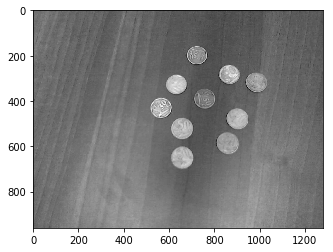

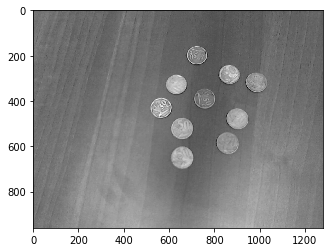

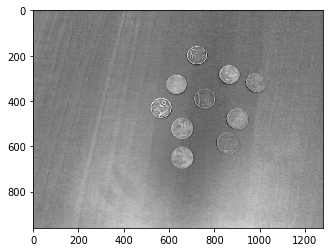

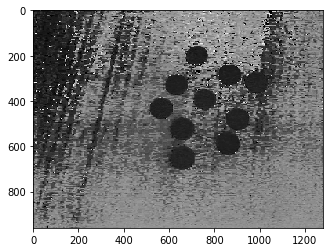

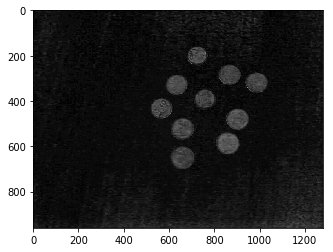

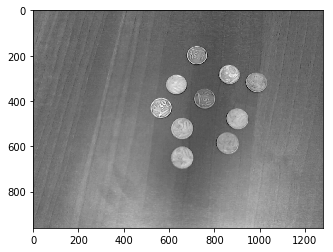

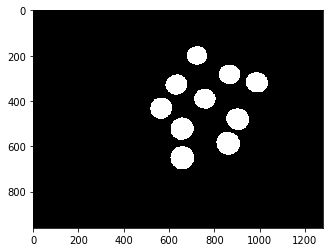

(960, 1280) (960, 1280)


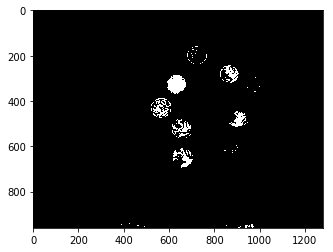

Accuracy: 95.78727213541667 %


In [11]:
# teepa1 = test_channel('coins/val1.jpg','coins/val_mask1.png','r','MAP',0,0,0,0,αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2)
teepa1 = test_channel('coins/val1.jpg','coins/val_mask1.png','v','ML',dσ,dμ,cμ,cσ,λ)

# Multivariate Data

## Naive Bayes Classifier

In [12]:
# might need to update to include 12 extra parameters - 1 set per channel x2 for picture and mask

def train_multi_channel(train_image, train_mask, colour_space, pixels=100, method='ML',α1=1, β1=1,γ1=1, δ1=0, 
                  α2=1, β2=1,γ2=1, δ2=0):
#    '''
#     args:
     
#         train_image: (String). Path to image file to be used for training the model.
                
#         train_mask: (String). Path to mask image file corresponding to train_image, 
#                     to be used for training the model.
        

#         colour_space: (String). Which colour_space to train on.
#                 'rgb'
#                 'hsv'


#         pixels: number of pixels to train on as percentage of image. 
#                 e.g 25 := train on 25% of the pixels from the training image


#         method: (String). Method for getting model parameters.
#                 'ML' := max likelihood, 
#                 'MAP' := max a posterior,
#                 'B' := Bayesian
                
                
#         Returns model parameters to be used in fitting a test image (see test_channel()).
#     '''

    # get channels from test_image:
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(train_image, train_mask)
    
    
    # seperate coins in each channel:
    # coin data
    data1 = extract_coins(r,mask)[:int(0.01*pixels*r.size)]
    data2 = extract_coins(g,mask)[:int(0.01*pixels*r.size)]
    data3 = extract_coins(b,mask)[:int(0.01*pixels*r.size)]
    data4 = extract_coins(h,mask)[:int(0.01*pixels*r.size)]
    data5 = extract_coins(s,mask)[:int(0.01*pixels*r.size)]
    data6 = extract_coins(v,mask)[:int(0.01*pixels*r.size)]
    
    # desk data
    desk1 = extract_desk(r,mask)[:int(0.01*pixels*r.size)]
    desk2 = extract_desk(g,mask)[:int(0.01*pixels*r.size)]
    desk3 = extract_desk(b,mask)[:int(0.01*pixels*r.size)]
    desk4 = extract_desk(h,mask)[:int(0.01*pixels*r.size)]
    desk5 = extract_desk(s,mask)[:int(0.01*pixels*r.size)]
    desk6 = extract_desk(v,mask)[:int(0.01*pixels*r.size)]
    

#     Use user-specified colour_space:
    if(colour_space=='rgb'):
        coin1 = data1
        coin2 = data2
        coin3 = data3
        deskA = desk1
        deskB = desk2
        deskC = desk3
    elif(colour_space == 'hsv'):
        coin1 = data4
        coin2 = data5
        coin3 = data6
        deskA = desk4
        deskB = desk5
        deskC = desk6
    
        

    
    
    # Get model parameters using the user-specified method:
    # This is currently assuming a normal distribution for the model and NormalInverseGamma as prior.
    if(method=='ML'):
        cμ1 = np.mean(coin1)
        cσ1 = np.var(coin1)

        dμ1 = np.mean(deskA)
        dσ1 = np.var(deskA)
        
        
        cμ2 = np.mean(coin2)
        cσ2 = np.var(coin2)

        dμ2 = np.mean(deskB)
        dσ2 = np.var(deskB)
        
        cμ3 = np.mean(coin3)
        cσ3 = np.var(coin3)

        dμ3 = np.mean(deskC)
        dσ3 = np.var(deskC)
        
#         from tut 4 (4.7)
        λ = coin1.size/r.size # ratio of coin pixels: pixels
        

        print('dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3, λ:', dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3, λ)
        return dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3,λ
   
    elif(method=='MAP'):
        
        cμ1 = (coin1.size*np.mean(coin1) + γ1*δ1) / (coin1.size + γ1)
        dμ1 = (deskA.size*np.mean(deskA) + γ2*δ2) / (deskA.size + γ2)
        
        cσ1 = ( (np.sum((coin1-cμ1)**2)) + 2*β1 + γ1*(δ1-cμ1)**2 ) / (coin1.size + 3 + 2*α1)
        dσ1 = ( (np.sum((deskA-dμ1)**2)) + 2*β2 + γ2*(δ2-dμ1)**2 ) / (deskA.size + 3 + 2*α2)
        
        #---
        cμ2 = (coin2.size*np.mean(coin2) + γ1*δ1) / (coin2.size + γ1)
        dμ2 = (deskB.size*np.mean(deskB) + γ2*δ2) / (deskB.size + γ2)
        
        cσ2 = ( (np.sum((coin2-cμ2)**2)) + 2*β1 + γ1*(δ1-cμ2)**2 ) / (coin2.size + 3 + 2*α1)
        dσ2 = ( (np.sum((deskB-dμ2)**2)) + 2*β2 + γ2*(δ2-dμ2)**2 ) / (deskB.size + 3 + 2*α2)
        
        #---
        cμ3 = (coin3.size*np.mean(coin3) + γ1*δ1) / (coin3.size + γ1)
        dμ3 = (deskC.size*np.mean(deskC) + γ2*δ2) / (deskC.size + γ2)
        
        cσ3 = ( (np.sum((coin3-cμ3)**2)) + 2*β1 + γ1*(δ1-cμ3)**2 ) / (coin3.size + 3 + 2*α1)
        dσ3 = ( (np.sum((deskC-dμ3)**2)) + 2*β2 + γ2*(δ2-dμ3)**2 ) / (deskC.size + 3 + 2*α2)
        
        
        
        #         from tut 4 (4.8)
        λ = (coin1.size + α1 -1)/(α1 + β1 + r.size -2) # ratio of coin pixels: pixels +- some parameters
        
        
        print('dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3, λ:', dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3, λ)
        return dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3,λ
    elif(method=='B'):
        αt1 = α1 + 0.5*data.size
        βt1 = 0.5*(np.sum(data**2)) + β1 + (0.5*γ1*(δ1**2)) - ( (γ1*δ1 + np.sum(data))**2 / (2*(γ1+data.size)) )
        γt1 = γ1 + data.size
        δt1 = (γ1*δ1 + np.sum(data)) / (γ1+data.size)
        
        αt2 = α2 + 0.5*desk.size
        βt2 = 0.5*(np.sum(desk**2)) + β2 + (0.5*γ2*(δ2**2)) - ( (γ2*δ2 + np.sum(desk))**2 / (2*(γ2+desk.size)) )
        γt2 = γ2 + desk.size
        δt2 = (γ2*δ2 + np.sum(desk)) / (γ2+desk.size)
        
        return αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2
    
    
    
    
    return 0
    
    
    

In [13]:
# only works with normal and bernoulli prior params for now
def test_multi_channel(test_image, test_mask, colour_space, method, dσ1=None,dμ1=None,cμ1=None,
                       cσ1=None,dσ2=None,dμ2=None,cμ2=None,cσ2=None,dσ3=None,dμ3=None,cμ3=None,cσ3=None,λ=None, 
                αt1=None,βt1=None,γt1=None,δt1=None,αt2=None,βt2=None,γt2=None,δt2=None):
    
    '''
        Returns an array with true where a coin pixel has been classified
    '''
    
    
#     ---------------------------- Helper functions ------------------------
    def Bayes_multivariate_Formula(coin_dist1,coin_dist2,coin_dist3,prior,desk_dist1,desk_dist2,desk_dist3):
#        Pr(x)= Bern(λ): Pr(x = 0) = 1 − λ
#               Pr(x = 1) = λ

        λ = prior
        Pr_coin = (λ*coin_dist1*coin_dist2*coin_dist3)/ ( ((1-λ)*desk_dist1*desk_dist2*desk_dist3) + (λ*coin_dist1*coin_dist2*coin_dist3) )
        return Pr_coin

    
    def stupid_classify(Pr_coin):
        return np.greater(Pr_coin, 0.5)
    
    
    def accuracy(test, mask):
        return (np.sum(test == mask)/(test.size))*100
        
        
    # the dumbest thing ever
    powvector = np.frompyfunc(mp.power, 2, 1)
    realvector = np.frompyfunc(mp.re,1,1)
    
#     ----------------------------------------------------------------------------




    # get channels from test_image:
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(test_image, test_mask)
    
#     print('mask',mask)
    
    # seperate test image into channels:
    data1 = r
    data2 = g
    data3 = b
    data4 = h
    data5 = s
    data6 = v
    

    

#     Use user-specified colour_space:
    if(colour_space=='rgb'):
        data1 = r
        data2 = g
        data3 = b
    elif(colour_space == 'hsv'):
        data1 = h
        data2 = s
        data3 = v

    
    
    
    
    # Get predicitive density using parameters generated by the user-specified method:
    # This is currently assuming a normal distribution for the model and NormalInverseGamma as prior.
    
    if(method=='ML'):
        #  stats.norm.pdf(x , mu, sigma) produces array holding a pdf mapped from x to  Norm_x(mu, sigm^2)
        # coin red/hue distribution:
        coin_dist1 = stats.norm.pdf(data1, cμ1, np.sqrt(cσ1) )
        # desk red/hue  distribution
        desk_dist1 = stats.norm.pdf(data1, dμ1, np.sqrt(dσ1) )
    
        # coin green/saturation distribution:
        coin_dist2 = stats.norm.pdf(data2, cμ2, np.sqrt(cσ2) )
        # desk green/saturation distribution
        desk_dist2 = stats.norm.pdf(data2, dμ2, np.sqrt(dσ2) )
        
        # coin blue/value distribution:
        coin_dist3 = stats.norm.pdf(data3, cμ3, np.sqrt(cσ3) )
        # desk blue/value distribution
        desk_dist3 = stats.norm.pdf(data3, dμ3, np.sqrt(dσ3) )
        
        
        # prior
        teepa = Bayes_multivariate_Formula(coin_dist1,coin_dist2,coin_dist3,λ,desk_dist1,desk_dist2,desk_dist3)
        nala = stupid_classify(teepa)
        see(nala)
        accuracy = accuracy(nala, mask)

        print("Accuracy:",accuracy,"%")
        return nala, accuracy
    
    elif(method=='MAP'):
        #  stats.norm.pdf(x , mu, sigma) produces array holding a pdf mapped from x to  Norm_x(mu, sigm^2)
        # coin red/hue distribution:
        coin_dist1 = stats.norm.pdf(data1, cμ1, np.sqrt(cσ1) )
        # desk red/hue  distribution
        desk_dist1 = stats.norm.pdf(data1, dμ1, np.sqrt(dσ1) )
    
        # coin green/saturation distribution:
        coin_dist2 = stats.norm.pdf(data2, cμ2, np.sqrt(cσ2) )
        # desk green/saturation distribution
        desk_dist2 = stats.norm.pdf(data2, dμ2, np.sqrt(dσ2) )
        
        # coin blue/value distribution:
        coin_dist3 = stats.norm.pdf(data3, cμ3, np.sqrt(cσ3) )
        # desk blue/value distribution
        desk_dist3 = stats.norm.pdf(data3, dμ3, np.sqrt(dσ3) )
        
        teepa = Bayes_multivariate_Formula(coin_dist1,coin_dist2,coin_dist3,λ,desk_dist1,desk_dist2,desk_dist3)
        nala = stupid_classify(teepa)
        see(nala)
        accuracy = accuracy(nala, mask)

        print("Accuracy:",accuracy,"%")
        return nala, accuracy
    
    elif(method=='B'):
        
        αc1 = αt1 + 0.5
        βc1 = 0.5*(data**2) + βt1 + 0.5*(γt1*(δt1**2)) -  0.5*(((γt1*δt1 + data)**2) / (γt1 + 1))
        γc1 = γt1 + 1
        
        αc2 = αt2 + 0.5
        βc2 = 0.5*(data**2) + βt2 + 0.5*(γt2*(δt2**2)) -  0.5*(((γt2*δt2 + data)**2) / (γt2 + 1))
        γc2 = γt2 + 1
        
        k1 = (   1/(np.sqrt(2*pi))  )
        k2 = ( (np.sqrt(γt1)*(mp.power(βt1,αt1)))/(np.sqrt(γc1)*(powvector(βc1,αc1))) )
        k3 = ( (mp.gamma(αc1)) / (mp.gamma(αt1)) )
        κc1 =  k1 * k2 * k3
    
    
        kk1 = (   1/(np.sqrt(2*pi))  )
        kk2 = ( (np.sqrt(γt2)*(mp.power(βt2,αt2)))/(np.sqrt(γc2)*(powvector(βc2,αc2))) )
        kk3 = ( (mp.gamma(αc2)) / (mp.gamma(αt2)) )
        κc2 =  kk1 * kk2 * kk3
    
        teepa = realvector(Bayes_multivariate_Formula(κc1,λ,κc2))
        nala = stupid_classify(teepa)
        print("Nala:")
        see(nala)
        accuracy = accuracy(nala, mask)
        print("Accuracy:",accuracy,"%")

#         print("kappa coins, kappa desk:",κc1,κc2)
        return nala, accuracy
    


r,g,b,h,s,v, mask


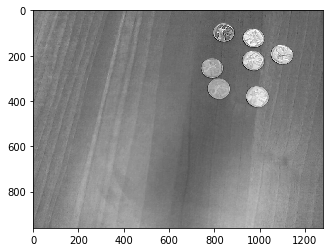

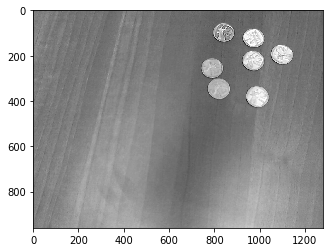

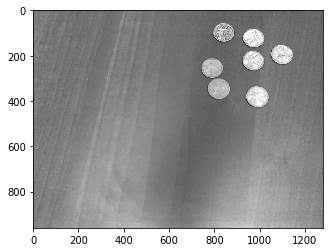

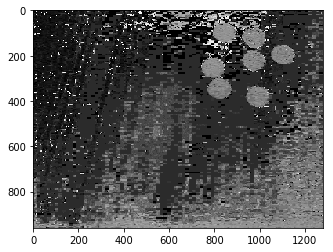

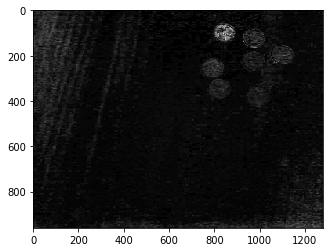

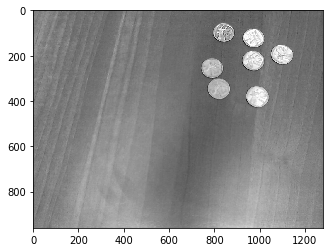

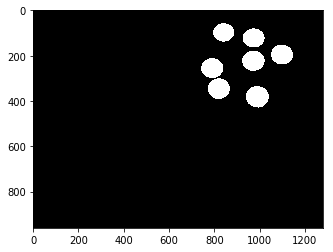

dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3, λ: 1015.4200066106553 43.9831224664235 91.55412338350646 243.98571810476798 30.7619665616652 6.395413962069345 20.309243163027347 209.8087782484825 337.18742140288947 137.2046224283405 202.11602713589144 1235.6543138326324 0.03838704427083333


In [14]:
# αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2= train_channel('coins/train.jpg','coins/mask.jpg', 'r', 1,'MAP' )
dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3, λ = train_multi_channel('coins/train.jpg','coins/mask.jpg', 'hsv', 100,'ML' )

r,g,b,h,s,v, mask


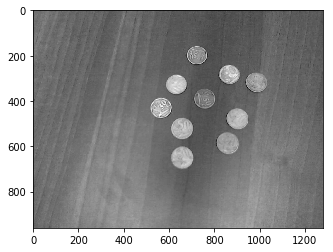

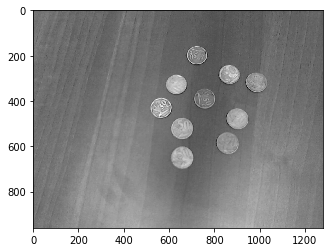

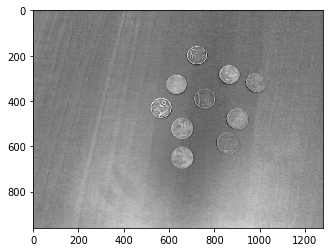

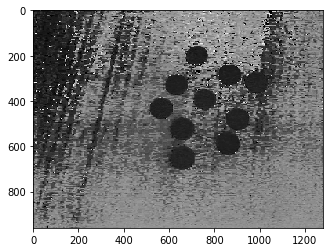

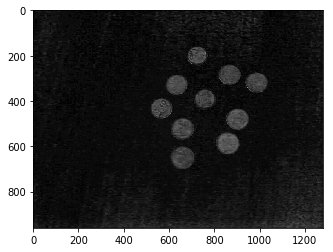

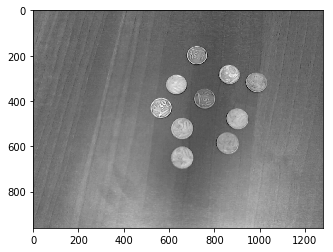

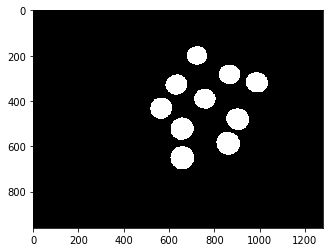

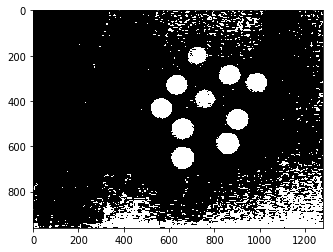

Accuracy: 89.85465494791667 %


In [15]:
# teepa1 = test_channel('coins/val1.jpg','coins/val_mask1.png','r','MAP',0,0,0,0,αt1,βt1,γt1,δt1,αt2,βt2,γt2,δt2)
teepa1 = test_multi_channel('coins/val1.jpg','coins/val_mask1.png','hsv','ML',dσ1,dμ1,cμ1,cσ1,dσ2,dμ2,cμ2,cσ2,dσ3,dμ3,cμ3,cσ3, λ)

# Multivariate Normal

In [175]:
# might need to update to include 12 extra parameters - 1 set per channel x2 for picture and mask

def train_multi_normal(train_image, train_mask, colour_space, pixels=100, method='ML'):
#    '''
#     args:
     
#         train_image: (String). Path to image file to be used for training the model.
                
#         train_mask: (String). Path to mask image file corresponding to train_image, 
#                     to be used for training the model.
        

#         colour_space: (String). Which colour_space to train on.
#                 'rgb'
#                 'hsv'


#         pixels: number of pixels to train on as percentage of image. 
#                 e.g 25 := train on 25% of the pixels from the training image


#         method: (String). Method for getting model parameters.
#                 'ML' := max likelihood, 
#                 'MAP' := max a posterior,
#                 'B' := Bayesian
                
                
#         Returns model parameters to be used in fitting a test image (see test_channel()).
#     '''

    # get channels from test_image:
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(train_image, train_mask)
    
    
    # seperate coins in each channel:
    # coin data
    data1 = extract_coins(r,mask)[:int(0.01*pixels*r.size)]
    data2 = extract_coins(g,mask)[:int(0.01*pixels*r.size)]
    data3 = extract_coins(b,mask)[:int(0.01*pixels*r.size)]
    data4 = extract_coins(h,mask)[:int(0.01*pixels*r.size)]
    data5 = extract_coins(s,mask)[:int(0.01*pixels*r.size)]
    data6 = extract_coins(v,mask)[:int(0.01*pixels*r.size)]
    
    # desk data
    desk1 = extract_desk(r,mask)[:int(0.01*pixels*r.size)]
    desk2 = extract_desk(g,mask)[:int(0.01*pixels*r.size)]
    desk3 = extract_desk(b,mask)[:int(0.01*pixels*r.size)]
    desk4 = extract_desk(h,mask)[:int(0.01*pixels*r.size)]
    desk5 = extract_desk(s,mask)[:int(0.01*pixels*r.size)]
    desk6 = extract_desk(v,mask)[:int(0.01*pixels*r.size)]
    

#     Use user-specified colour_space:
    if(colour_space=='rgb'):
        coin1 = data1
        coin2 = data2
        coin3 = data3
    
        deskA = desk1
        deskB = desk2
        deskC = desk3
        
        coins = np.stack((coin1,coin2,coin3))
        desk = np.stack((deskA,deskB,deskC))
        
    elif(colour_space == 'hsv'):
        coin1 = data4
        coin2 = data5
        coin3 = data6
        
        deskA = desk4
        deskB = desk5
        deskC = desk6
        
        coins = np.stack((coin1,coin2,coin3))
        desk = np.stack((deskA,deskB,deskC))
        
    elif(colour_space == 'rgbhsv'):
        coin1 = data1
        coin2 = data2
        coin3 = data3
    
        deskA = desk1
        deskB = desk2
        deskC = desk3
    
        coin4 = data4
        coin5 = data5
        coin6 = data6
        
        deskD = desk4
        deskE = desk5
        deskF = desk6
    
        # Stack the data into a matrix with 1 row per channel and num_pixels columns
        coins = np.stack((coin1,coin2,coin3,coin4,coin5,coin6))
        desk = np.stack((deskA,deskB,deskC,deskD,deskE,deskF))
        
    # Do stupid parameter calculations here for this one
        cμ1 = np.mean(coin1)
        dμ1 = np.mean(deskA) 
        
        cμ2 = np.mean(coin2)
        dμ2 = np.mean(deskB)    
        
        cμ3 = np.mean(coin3)
        dμ3 = np.mean(deskC)        
        
        cμ4 = np.mean(coin4)
        dμ4 = np.mean(deskD)  
        
        cμ5 = np.mean(coin5)
        dμ5 = np.mean(deskE)  
        
        cμ6 = np.mean(coin6)
        dμ6 = np.mean(deskF)  
        
        μc = np.array([cμ1,cμ2,cμ3,cμ4,cμ5,cμ6])
        Σc = np.cov(coins)

        μd = np.array([dμ1,dμ2,dμ3,dμ4,dμ5,dμ6])
        Σd = np.cov(desk)
        
#         from tut 4 (4.7) (using ML)
        λ = coin1.size/r.size # ratio of coin pixels: pixels
        

        print('μc,Σc,μd,Σd,λ:', μc,Σc,μd,Σd,λ)
        return μc,Σc,μd,Σd,λ



        

    
    # Get model parameters using the user-specified method:
    # This is currently assuming a normal distribution for the model and NormalInverseGamma as prior.
    if(method=='ML'):
        cμ1 = np.mean(coin1)
        dμ1 = np.mean(deskA) 
        
        cμ2 = np.mean(coin2)
        dμ2 = np.mean(deskB)    
        
        cμ3 = np.mean(coin3)
        dμ3 = np.mean(deskC)        
        
        μc = np.array([cμ1,cμ2,cμ3])
        Σc = np.cov(coins)

        μd = np.array([dμ1,dμ2,dμ3])
        Σd = np.cov(desk)
        
#         from tut 4 (4.7) (using ML)
        λ = coin1.size/r.size # ratio of coin pixels: pixels
        

        print('μc,Σc,μd,Σd,λ:', μc,Σc,μd,Σd,λ)
        return μc,Σc,μd,Σd,λ
   
   
    
    
    
    
    return 0
    
    
    

In [176]:
# only works with normal and bernoulli prior params for now
def test_multi_normal(test_image, test_mask, colour_space, method, μc,Σc,μd,Σd,λ):
    
    '''
        Returns an array with true where a coin pixel has been classified
    '''
    
    
#     ---------------------------- Helper functions ------------------------
    def Bayes_multivariate_normal_Formula(coin_dist,prior,desk_dist):
#        Pr(x)= Bern(λ): Pr(x = 0) = 1 − λ
#               Pr(x = 1) = λ

        λ = prior
        Pr_coin = (λ*coin_dist)/ ( ( (1-λ)*desk_dist) + (λ*coin_dist) )
        return Pr_coin

    
    def stupid_classify(Pr_coin):
        return np.greater(Pr_coin, 0.5)
    
    
    def accuracy(test, mask):
        return (np.sum(test == mask)/(test.size))*100
        
        
    # the dumbest thing ever
    powvector = np.frompyfunc(mp.power, 2, 1)
    realvector = np.frompyfunc(mp.re,1,1)
    
#     ----------------------------------------------------------------------------




    # get channels from test_image:
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(test_image, test_mask)
    


#     Use user-specified colour_space:
    # seperate test image into channels and flatten them:

    if(colour_space=='rgb'):
        data1 = np.ravel(r)
        data2 = np.ravel(g)
        data3 = np.ravel(b)
        data = np.stack((data1,data2,data3))
      
    elif(colour_space == 'hsv'):
        data1 = np.ravel(h)
        data2 = np.ravel(s)
        data3 = np.ravel(v)
        data = np.stack((data1,data2,data3))
    elif(colour_space == 'rgbhsv'):
        data1 = np.ravel(r)
        data2 = np.ravel(g)
        data3 = np.ravel(b)
        data4 = np.ravel(h)
        data5 = np.ravel(s)
        data6 = np.ravel(v)
    
    
    
        data = np.stack((data1,data2,data3,data4,data5,data6))

    
    
    
    
    # Get predicitive density using parameters generated by the user-specified method:
    # This is currently assuming a multivariate normal distribution for the model.
    
    if(method=='ML'):
#          μc.size, Σc.size
        print('data, μc, Σc',data.shape,μc.shape,Σc.shape)
        coin_dist = stats.multivariate_normal.pdf(data.T, μc, Σc)
        desk_dist = stats.multivariate_normal.pdf(data.T, μd, Σd)      
        
        # prior
        teepa = Bayes_multivariate_normal_Formula(coin_dist,λ,desk_dist)
        nala = np.reshape(stupid_classify(teepa),r.shape)
        see(nala)
        accuracy = accuracy(nala, mask)

        print("Accuracy:",accuracy,"%")
        return nala, accuracy
    

    
   



r,g,b,h,s,v, mask


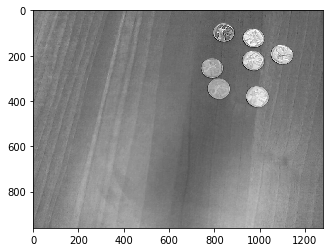

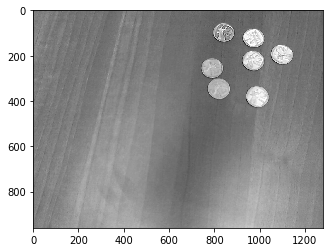

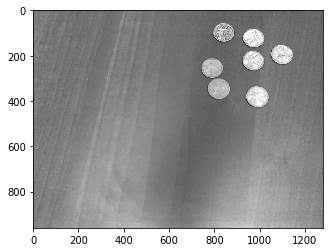

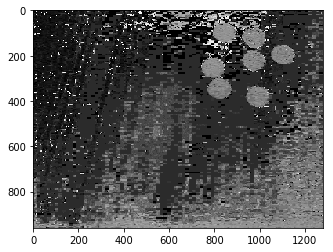

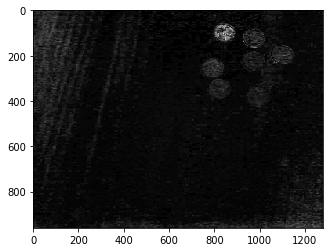

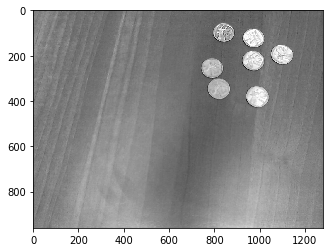

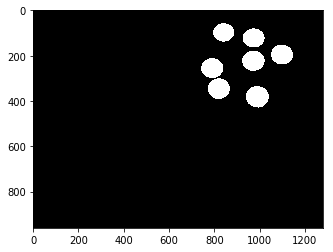

μc,Σc,μd,Σd,λ: [ 91.55412338  20.30924316 202.11602714] [[ 243.99089069   83.4800611   110.53143553]
 [  83.4800611   209.81322627 -119.49836731]
 [ 110.53143553 -119.49836731 1235.68051015]] [ 43.98312247   6.39541396 137.20462243] [[1015.42086595    8.10788897  179.67949313]
 [   8.10788897   30.7619926    13.85919916]
 [ 179.67949313   13.85919916  337.18770676]] 0.03838704427083333


In [177]:
μc,Σc,μd,Σd,λ= train_multi_normal('coins/train.jpg','coins/mask.jpg', 'hsv', 100,'ML' )

In [1]:
teepa1 = test_multi_normal('coins/val1.jpg','coins/val_mask1.png','hsv','ML',μc,Σc,μd,Σd,λ)

NameError: name 'test_multi_normal' is not defined

In [3]:
np.abs(15541510.741718762 - 15533001.050388033)

8509.691330729052

In [12]:
# extra

In [13]:
def extract_coins_red(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location

# NB !!! MASK IS IN BGR

    i, j = np.where(mask[:,:,2] == 255)
    coins=img[i,j]
    return coins

In [14]:
def extract_coins_blue(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location

# NB !!! MASK IS IN BGR
    i, j = np.where(mask[:,:,0] == 255)
    coins=img[i,j]
    return coins

In [15]:
def extract_desk(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location

# NB !!! MASK IS IN BGR

    i, j = np.where(mask[:,:,1] == 255)
    desk=img[i,j]
    return desk

In [16]:
def get_channels(img):
    # import images (will be in bgr because of cv2)
    img_bgr = cv2.imread(img)
#     mask_bgr = cv2.imread(mask)
    
    # binarise the mask because it contains grey pixels due to interpolation from jpeg compression:
#     binary = skimage.filters.threshold_otsu(mask_bgr[:,:,0])
#     m = mask_bgr[:,:,0]>binary
    
    # get r,g, and b of img_bgr:
    img_r = img_bgr[:,:,2]
    img_g = img_bgr[:,:,1]
    img_b = img_bgr[:,:,0]
    
    # convert img_bgr to HSV:
    img_hsv = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2HSV)
    
    # get H, S and V of img_hsv
    img_H = img_hsv[:,:,0]
    img_S = img_hsv[:,:,1]
    img_V = img_hsv[:,:,2]
    
    print('r,g,b,h,s,v')
    see(img_r)
    see(img_g)
    see(img_b)
    see(img_H)
    see(img_S)
    see(img_V)
#     see(m)
    
    return(img_r,img_g,img_b,img_H,img_S,img_V)

In [17]:
mask = cv2.imread('l67.png')

In [18]:
I = get_channels('t67.jpg')

TypeError: 'NoneType' object is not subscriptable

In [19]:
red_coins = extract_coins_red(I[3],mask) #H
blue_coins = extract_coins_blue(I[3],mask) #H
desk = extract_desk(I[3], mask) #H

NameError: name 'I' is not defined

In [20]:
cμr = np.mean(red_coins)
cσr = np.var(red_coins)

cμb = np.mean(blue_coins)
cσb = np.var(blue_coins)

dμ = np.mean(desk)
dσ = np.var(desk)

#         from tut 4 (4.7)
λr = red_coins.size/I[0].size # ratio of coin pixels: pixels
λb = blue_coins.size/I[0].size # ratio of coin pixels: pixels
λd = desk.size/I[0].size # ratio of coin pixels: pixels


print('cμr,cσr, λr \n cμb,cσb λb \n λd:',cμr,cσr, λr,cμb,cσb,λb,λd)
# return cμr,cσr, λr,dμb,cμb,λb,λd

print('λr, λb,λd',λr, λb,λd)

NameError: name 'red_coins' is not defined

In [21]:
red_coins.shape

NameError: name 'red_coins' is not defined

In [22]:
red_coins1 = extract_coins_red(I[3],mask)[:100] #H
blue_coins1 = extract_coins_blue(I[3],mask)[:100] #H
desk1 = extract_desk(I[3], mask)[:100] #H

NameError: name 'I' is not defined

In [23]:
cμr = np.mean(red_coins1)
cσr = np.var(red_coins1)

cμb = np.mean(blue_coins1)
cσb = np.var(blue_coins1)

dμ = np.mean(desk1)
dσ = np.var(desk1)

#         from tut 4 (4.7)

print('cμr,cσr, λr,',cμr,cσr,λr,'\n cμb,cσb λb',cμb,cσb,λb,'\n ,dμ,dσ λd:',dμ,dσ,λd)
# return cμr,cσr, λr,dμb,cμb,λb,λd

# print('λr, λb,λd',λr, λb,λd)

NameError: name 'red_coins1' is not defined

In [24]:
# MAP

def MAP(data,full_channel,δ1):
    γ1 =100.0
    β1 =1.0
    α1 =0.1
    cμ = (full_channel.size*np.mean(data) + γ1*δ1) / (full_channel.size + γ1)
    # dμ = (desk.size*np.mean(desk) + γ2*δ2) / (desk.size + γ2)

    cσ = ( (np.sum((data-cμ)**2)) + 2*β1 + γ1*(δ1-cμ)**2 ) / (full_channel.size + 3 + 2*α1)
    # dσ = ( (np.sum((desk-dμ)**2)) + 2*β2 + γ2*(δ2-dμ)**2 ) / (desk.size + 3 + 2*α2)

    print('cμ,cσ: ',cμ,cσ)
    return cμ,cσ

In [25]:
red = MAP(red_coins1, red_coins,60)

NameError: name 'red_coins1' is not defined

In [26]:
green = MAP(desk1,desk,80)

NameError: name 'desk1' is not defined

In [27]:
blue = MAP(blue_coins1,blue_coins,20)

NameError: name 'blue_coins1' is not defined